# Cup04: Unlearnable Dataset
110065508 李丞恩

In [1]:
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 64 
EPOCHS = 100
EPOCH_DENOISE = 20
PATIENCE = 10 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 2
LR = 0.001
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 4 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'ResNet50_cup04_cifar10'
MODEL_PATH = './model/' + MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
AUTO = tf.data.AUTOTUNE

## 一. 引入Dataset

In [5]:
x_train = np.load('./dataset/x_train_cifar10_unlearn.npy')
y_train = np.load('./dataset/y_train_cifar10.npy')
x_val = np.load('./dataset/x_val_cifar10.npy')
y_val = np.load('./dataset/y_val_cifar10.npy')
x_test = np.load('./dataset/x_test_cifar10.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

## 二. Auto encoder & decoder
### 1. 搭建自動編解碼器

In [20]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=INPUT_SHAPE),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
autoencoder = Denoise()
autoencoder.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
autoencoder.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

In [8]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 8)           1160      
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 16, 16, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 3)         435       
Total params: 2,187
Trainable params: 2,187
Non-trainable params: 0
_________________________________________________________________


### 2. 執行降噪

In [10]:
X = np.concatenate((x_train, x_val, x_test), axis=0)

In [11]:
autoencoder.fit(X, X,
                epochs=EPOCH_DENOISE,
                shuffle=True)

Epoch 1/20
1875/1875 [==============================] - 34s 16ms/step - loss: 0.0081
Epoch 2/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0036
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0028
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0026
Epoch 5/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0024
Epoch 6/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0023
Epoch 7/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0021 0s - loss: 0.002 - ETA:
Epoch 8/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0020
Epoch 9/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0019
Epoch 10/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0019
Epoch 11/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0018
Epoch 12/20
1875/1875 [================

In [12]:
del X

In [13]:
autoencoder.save_weights('./model/autoencoder.hdf5')

## 三. 資料前處理

In [22]:
autoencoder.load_weights('./model/autoencoder.hdf5')

In [9]:
def mixup(images, labels):
    alpha = tf.random.uniform([], 0, 1)
    image_denoise = autoencoder(tf.reshape(images,(-1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2])))
    mixedup_images = (alpha * image_denoise +
                     (1 - alpha) * tf.reverse(image_denoise, axis=[0]))
    return (mixedup_images, labels)

In [10]:
def mixup_dataset(dataset):
    mixup_ds = dataset.map(mixup, num_parallel_calls=AUTO)
    dataset = dataset.concatenate(mixup_ds)
    dataset = dataset.shuffle(BATCH_SIZE*10)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = mixup_dataset(train_dataset)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = mixup_dataset(val_dataset)

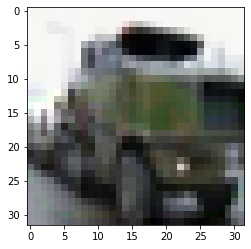

In [12]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

In [13]:
del autoencoder

## 三. 模型搭建

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=INPUT_SHAPE),
    layers.experimental.preprocessing.RandomContrast(factor = 0.5),
    layers.experimental.preprocessing.Normalization()
])

In [15]:
model = Sequential([
    data_augmentation,
    ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=INPUT_SHAPE), 
    Flatten(),
    Dropout(0.5),
    Dense(CATGORICAL, activation='softmax', name='softmax')
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "ResNet50_cup04_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         7         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
softmax (Dense)              (None, 2)                 4098      
Total params: 23,591,817
Trainable params: 23,538,690
Non-trainable params: 53,127
_________________________________________________________________


In [16]:
loss_fn = tf.losses.BinaryCrossentropy(from_logits=True) #SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## 四. 模型訓練

In [17]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)
callbacks_list = [checkpoint, reduceLROnPlat, early]

In [35]:
start = datetime.datetime.now()
history = model.fit(x=batched_dataset, 
                    validation_data=batched_val_dataset, 
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1)
end = datetime.datetime.now()
CNN_time = end - start

Epoch 1/100


ValueError: in user code:

    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        self._build_graph_network_for_inferred_shape(inputs.shape, inputs.dtype)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\tracking\base.py:522 _method_wrapper
        result = method(self, *args, **kwargs)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:281 _build_graph_network_for_inferred_shape
        input_shape = tuple(input_shape)
    C:\Users\acer\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\tensor_shape.py:868 __iter__
        raise ValueError("Cannot iterate over a shape with unknown rank.")

    ValueError: Cannot iterate over a shape with unknown rank.


## 五. 繪製結果

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
epoch = len(history.history['acc'])
train_acc = np.max(history.history['acc'])
val_acc = np.max(history.history['val_acc'])

In [ ]:
localtime = time.strftime("%Y-%m-%d %I:%M:%S %p", time.localtime())
with open('./output/result_cifar10.txt',  'a') as file_obj:
    file_obj.write('================RUN TIME: '+ localtime+ '================' + '\n')
    file_obj.write('model_name: '    + str(MODEL_NAME)        + '\n')
    file_obj.write('epoch: '         + str(epoch)             + '\n')
    file_obj.write('training time: ' + str(CNN_time)          + '\n')
    file_obj.write('train_acc: '     + str(train_acc)     + '\n')
    file_obj.write('val_acc: '       + str(val_acc)       + '\n')

## 六. 繳交

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

Make submit file

In [ ]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('./output/cup04_cifar10_group2.csv', index=False)